<a href="https://colab.research.google.com/github/Luke-687/Simulating-Chemotaxis--Q-learning-and-Heuristic-/blob/main/Chemotaxis_QLearning_(Basic_Simulation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import matplotlib.pyplot as plt

In [ ]:
#Agent class for everything
class agent:
  def __init__(self, alpha, gamma, epsilon, s):
    self.alpha=alpha
    self.gamma=gamma
    self.epsilon = epsilon
    self.s = s
    self.Qtable = {}
    for i1 in range(0,20):
      for j1 in range(0,20):
        for direction in range(0,8):
          for velocity in range(1,4):
            self.Qtable[((i1,j1),(direction, velocity))] = [0, self.moveForQTable(i1,j1, direction, velocity)] # Added self.

  #Following 4 functions to define Q-table and train
  def moveForQTable(self, initX, initY, direction, velocity): # Added self
    direction = self.directionKey(direction) # Added self.
    return [(initX + int(math.cos(direction)*velocity)),(initY + int(math.sin(direction)*velocity))]
  def directionKey(self, direction): # Added self
    angle = direction*45
    return angle*math.pi/180
  def reward(self, x, y): # Added self
    fromCenter = math.sqrt((x-9.5)**2+(y-9.5)**2)
    if(fromCenter<=5):
      reward = 10/(fromCenter**self.s)
    elif(int(fromCenter) == 0):
      reward=50
    else:
      reward=-50
    return reward
  def brownianMotion():
    result = [0,0]
    xChange = random.random()/4
    yChange = random.random()/4
    for i in range(10):
      xChange+= random.random()/100 * (-1**(random.randint(1,2)))
      yChange+= random.random()/100 * (-1**(random.randint(1,2)))
    result = [xChange, yChange]
    return result

  def trainQTable(self, trainingEpisodes, perc):
    trainingRewards = [[],[]]
    for iterations in range(trainingEpisodes):
      totReward=0

      #Starting position some (x,y) outside of gradient:
      currentX = 0
      currentY = 0

      #percentage difference in epsilon from inside to outside gradient = "perc"

      for steps in range(0,50):
        direction, velocity = max(
            [(d,v) for d in range(8) for v in range(1,4)],
            key=lambda a: self.Qtable[(int(currentX),int(currentY)),a][0] # Convert to int
        )
        fromCenter = math.sqrt((currentX-9.5)**2+(currentY-9.5)**2)
        if(fromCenter>5):
          tempEpsilon = self.epsilon+perc
          if(random.random()<tempEpsilon):
            direction = random.randint(0,7)
            velocity = random.randint(1,3)
        else:
          if(random.random()<self.epsilon):
            direction = random.randint(0,7)
            velocity = random.randint(1,3)
        nextPos = self.moveForQTable(currentX, currentY, direction, velocity)
        #Apply Brownian motion to the next position
        XYBrown = brownianMotion()
        nextX = max(0, min(19, nextPos[0]+XYBrown[0]))
        nextY = max(0, min(19, nextPos[1]+XYBrown[1]))
        initReward = self.reward(nextX, nextY)
        nextReward = max(
            self.Qtable[(int(nextX), int(nextY)), (d,v)][0] # Convert to int
            for d in range(8)
            for v in range(1,4)
        )
        self.Qtable[((int(currentX),int(currentY)),(direction, velocity))][0] = self.Qtable[((int(currentX),int(currentY)),(direction, velocity))][0] + self.alpha*(initReward + self.gamma*nextReward-self.Qtable[((int(currentX),int(currentY)),(direction, velocity))][0]) # Convert to int
        currentX = nextX
        currentY = nextY
        totReward+=self.Qtable[((int(currentX),int(currentY)),(direction, velocity))][0] + self.alpha*(initReward + self.gamma*nextReward-self.Qtable[((int(currentX),int(currentY)),(direction, velocity))][0]) # Convert to int
      trainingRewards[0].append(iterations)
      trainingRewards[1].append(totReward)
    return trainingRewards

  def simulate(self, steps, perc): # Added self
    x=[]
    y=[]

    #Starting position is some (x,y) outside of gradient
    currentX = 0
    currentY = 0

    for steps in range(0,steps):
      currentX = max(0, min(19, currentX))
      currentY = max(0, min(19, currentY))
      x.append(currentX)
      y.append(currentY)
      rewardOption = -100000
      currentX = int(currentX)
      currentY = int(currentY)
      nextPos = [currentX, currentY]
      for direction in range(0,8):
        for velocity in range(1,4):
          testReward = self.Qtable[(currentX, currentY), (direction, velocity)][0]
          if(testReward>=rewardOption):
            rewardOption = testReward
            nextPos = self.Qtable[(currentX, currentY), (direction, velocity)][1]
      #Make the agent more random outside gradient:
      fromCenter = math.sqrt((currentX-9.5)**2+(currentY-9.5)**2)
      if(fromCenter>5):
        tempEpsilon = self.epsilon+perc
        if(random.random()<tempEpsilon):
          nextPos = self.Qtable[(currentX, currentY), (random.randint(0,7), random.randint(1,3))][1]
      tempBrownian = brownianMotion()
      XYBrown = tempBrownian.setBrownian()
      currentX = nextPos[0] + XYBrown[0]
      currentY = nextPos[1] + XYBrown[1]
    return x,y


In [ ]:
#Gradient class
class gradient:
  def __init__(self, xSize, ySize):
    self.dimensions = [xSize, ySize]
  def createGradient(self, s):
    #s is for the steepness
    xG =[]
    yG = []
    gradient_values = []
    for x in range(0, self.dimensions[1]+1):
      for y in range(0, self.dimensions[0]+1):
        xG.append(x)
        yG.append(y)
        if(math.sqrt((x-(self.dimensions[0]/2))**2+(y-(self.dimensions[1]/2))**2)<=5):
          if(math.sqrt((x-9.5)**2+(y-9.5)**2)>1):
            gradient_values.append(1/(((x-9.5)**2+(y-9.5)**2)**s))
          else:
            gradient_values.append(1)
        else:
          gradient_values.append(0)

    return xG, yG, gradient_values

In [ ]:
#Simulate the model 1000 times and provide a graph of the average distance from the center at each step as well as a graph of the average change in distance from the center at each step
class graphs:
  def __init__(self, alpha, gamma, epsilon, steepness):
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.steepness = steepness
  def graphOfAverageDist(self):
    steps = []
    averageDist = []
    for i in range(30):
      steps.append(i)
      averageDist.append(0)
    for run in range(100):
      tempAgent = agent(self.alpha, self.gamma, self.epsilon)
      tempAgent.trainQTable(100, self.steepness)
      xTemp, yTemp = tempAgent.simulate(30)
      for step in range(len(xTemp)):
        fromCenter = math.sqrt((xTemp[step]-9.5)**2+(yTemp[step]-9.5)**2)
        averageDist[step] += fromCenter/100
    return steps, averageDist
  def graphOfAverageDistChange(self):
    steps = []
    averageDistChange = []
    for i in range(29):
      steps.append(i)
    for i in range(29):
      averageDistChange.append(0)
    for run in range(100):
      tempAgent = agent(self.alpha, self.gamma, self.epsilon)
      tempAgent.trainQTable(100, self.steepness)
      xTemp, yTemp = tempAgent.simulate(30)
      pastDist = math.sqrt((xTemp[0]-9.5)**2+(yTemp[0]-9.5)**2)
      for step in range(1, len(xTemp)):
        currentDist = math.sqrt((xTemp[step]-9.5)**2+(yTemp[step]-9.5)**2)
        averageDistChange[step-1] += (pastDist-currentDist)/100
        pastDist = currentDist
    return steps, averageDistChange
  def graphStepsToCenter(self):
    numSteps = 0
    for run in range(100):
      tempAgent = agent(self.alpha, self.gamma, self.epsilon)
      tempAgent.trainQTable(100, self.steepness)
      xTemp, yTemp = tempAgent.simulate(30)
      for step in range(len(xTemp)):
        currentDist = math.sqrt((xTemp[step]-9.5)**2+(yTemp[step]-9.5)**2)
        if(currentDist<=5):
          numSteps+=step/100
          break
        if(step == len(xTemp)-1):
          numSteps+=step/100
    return numSteps
  def graphWorst(self):
    maxDist = 0
    xReturn = []
    yReturn = []
    for run in range(100):
      tempAgent = agent(self.alpha, self.gamma, self.epsilon)
      tempAgent.trainQTable(100, self.steepness)
      xTemp, yTemp = tempAgent.simulate(30)
      totalDist = 0
      for step in range(len(xTemp)):
        totalDist+=math.sqrt((xTemp[step]-9.5)**2+(yTemp[step]-9.5)**2)
      if(totalDist>maxDist):
        maxDist = totalDist
        xReturn.clear()
        yReturn.clear()
        for i in range(len(xTemp)):
          xReturn.append(i)
          yReturn.append(math.sqrt((xTemp[i]-9.5)**2+(yTemp[i]-9.5)**2))
    return xReturn, yReturn
  def graphBest(self):
    minDist = 10000
    xReturn = []
    yReturn = []
    for run in range(100):
      tempAgent = agent(self.alpha, self.gamma, self.epsilon)
      tempAgent.trainQTable(100, self.steepness)
      xTemp, yTemp = tempAgent.simulate(30)
      totalDist = 0
      for step in range(len(xTemp)):
        totalDist+=math.sqrt((xTemp[step]-9.5)**2+(yTemp[step]-9.5)**2)
      if(totalDist<minDist):
        minDist = totalDist
        xReturn.clear()
        yReturn.clear()
        for i in range(len(xTemp)):
          xReturn.append(i)
          yReturn.append(math.sqrt((xTemp[i]-9.5)**2+(yTemp[i]-9.5)**2))
    return xReturn, yReturn

In [ ]:
#Key values which can be alterred
alpha = 0.99
gamma = 0.99
epsilon = 0.15
steepness = 0.85

/tmp/ipython-input-319923444.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


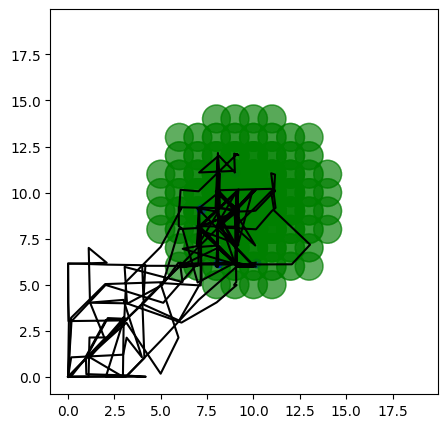

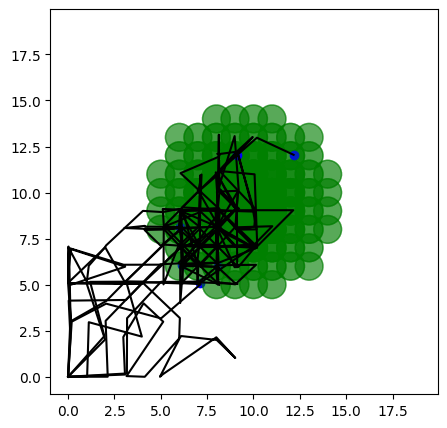

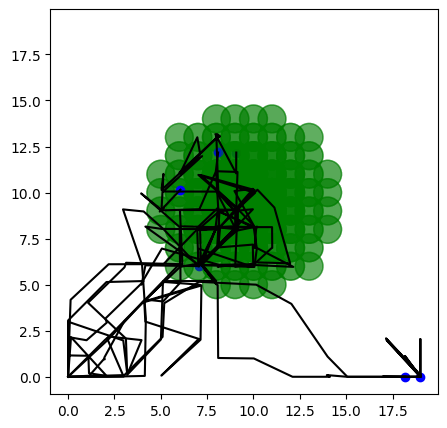

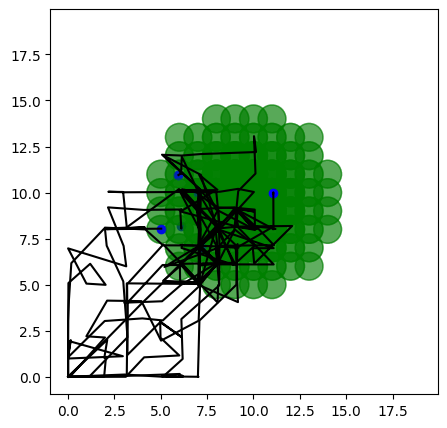

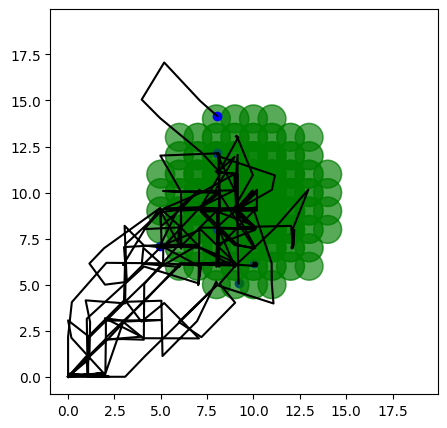

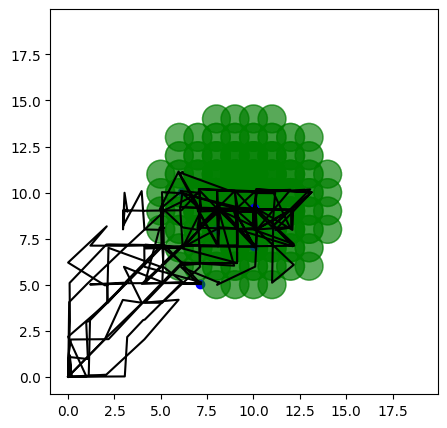

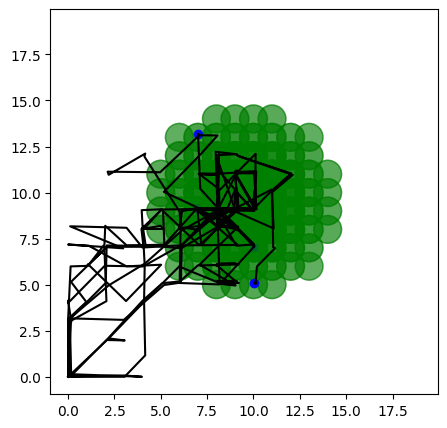

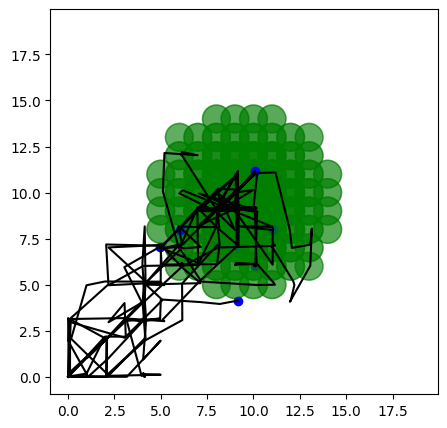

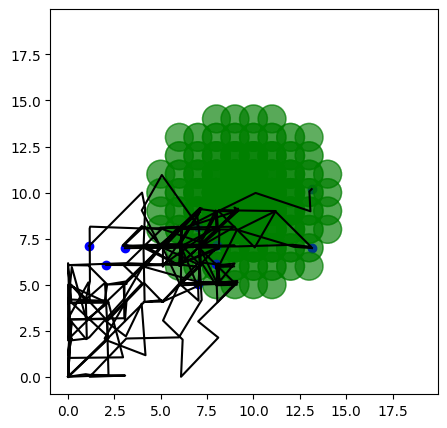

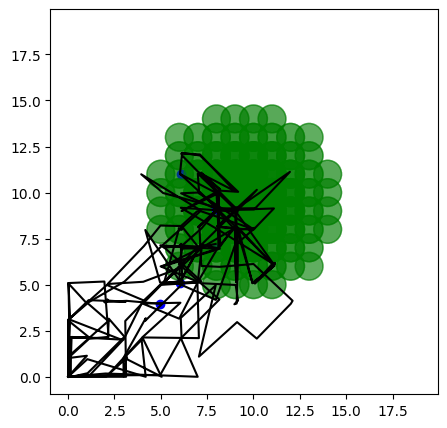

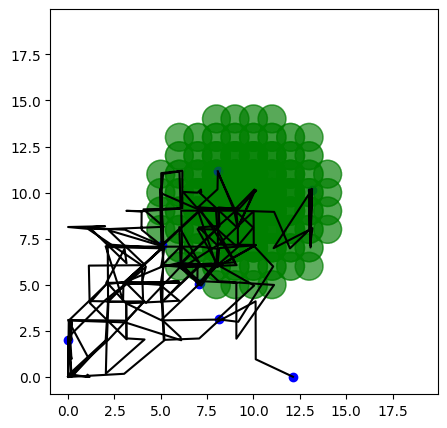

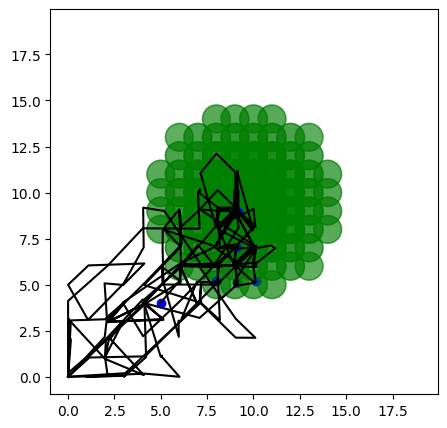

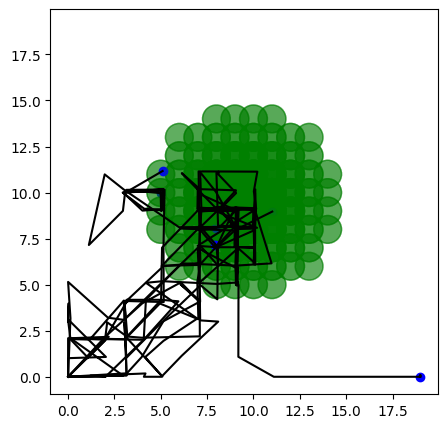

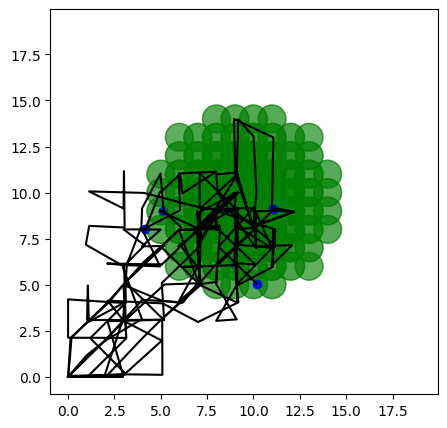

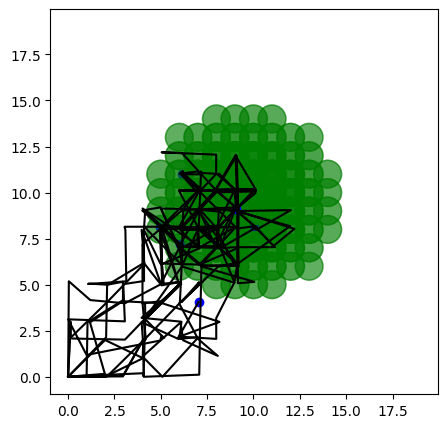

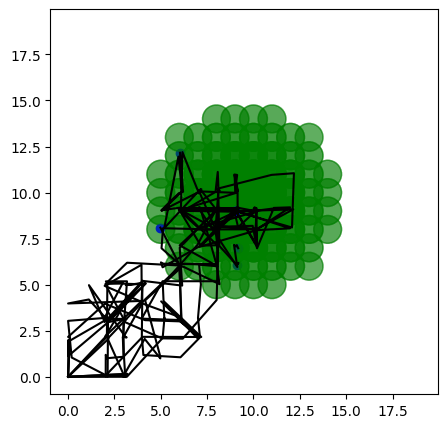

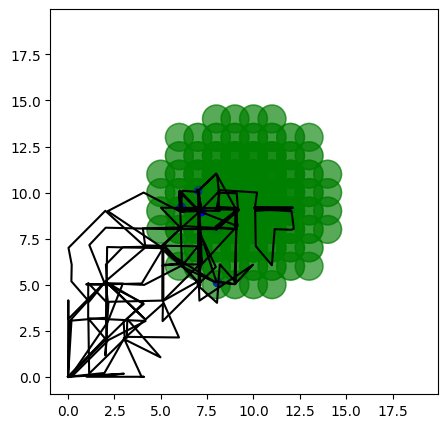

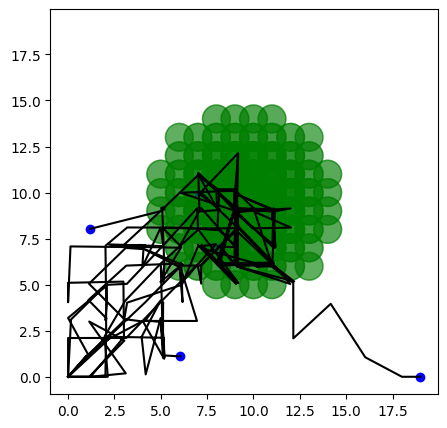

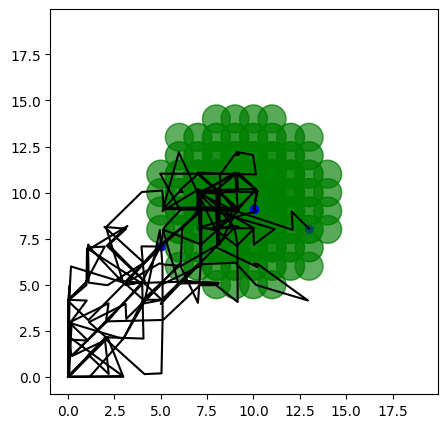

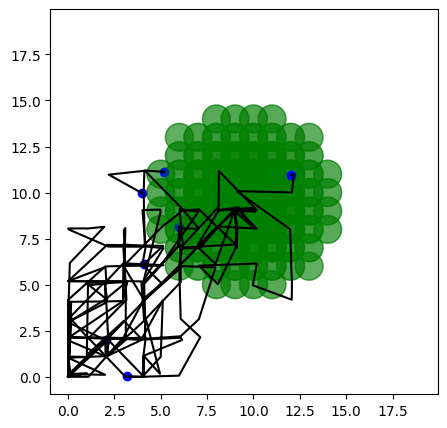

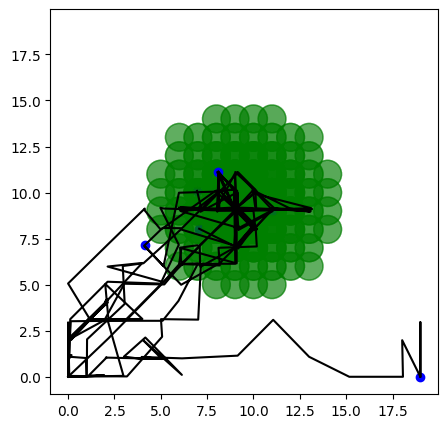

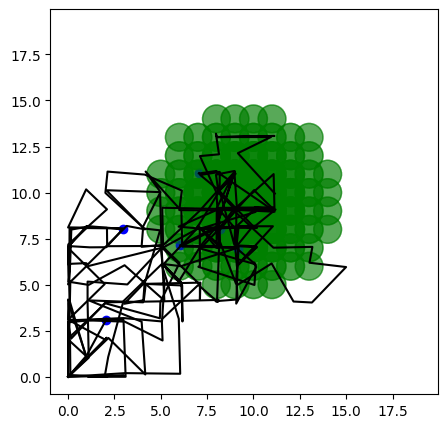

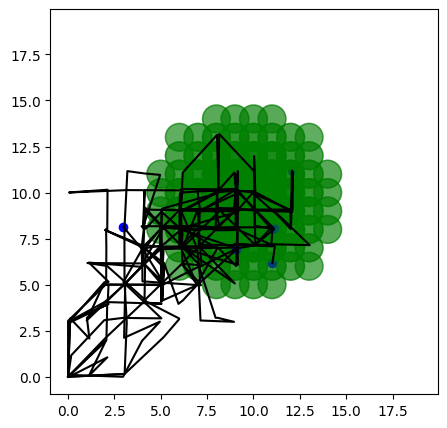

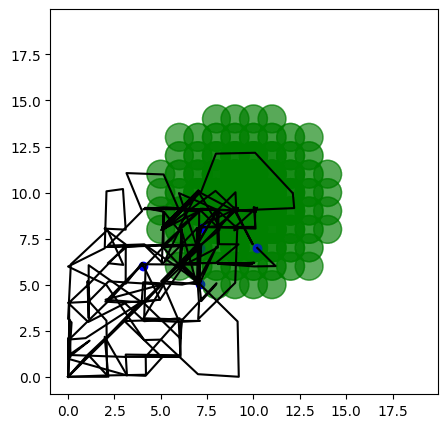

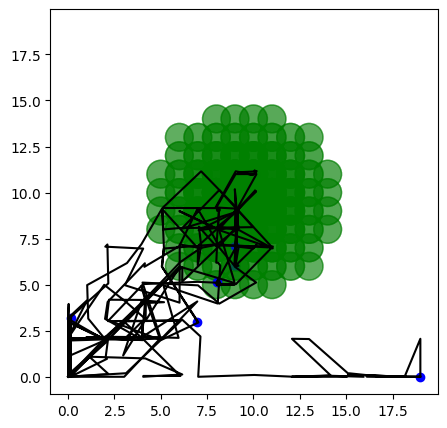

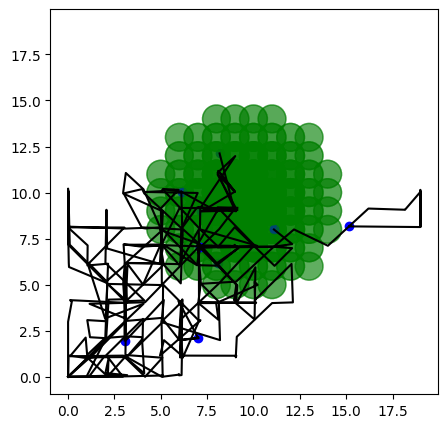

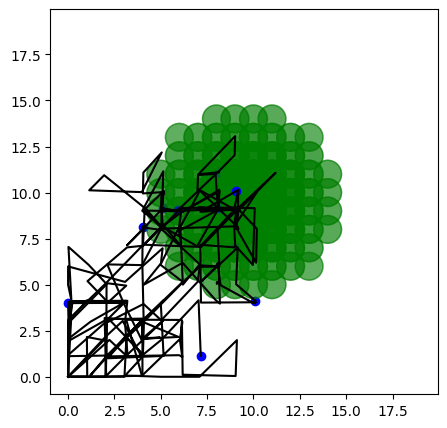

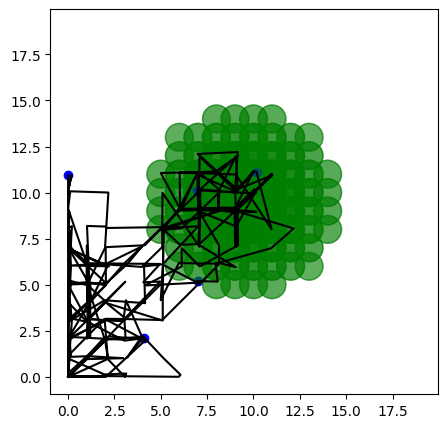

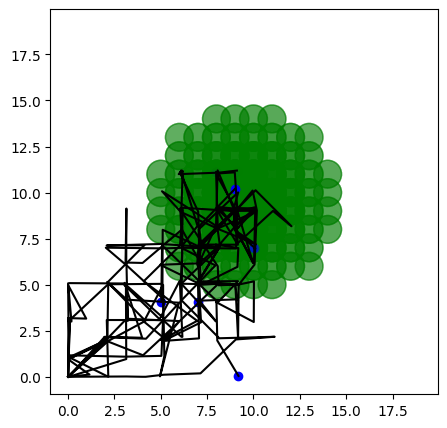

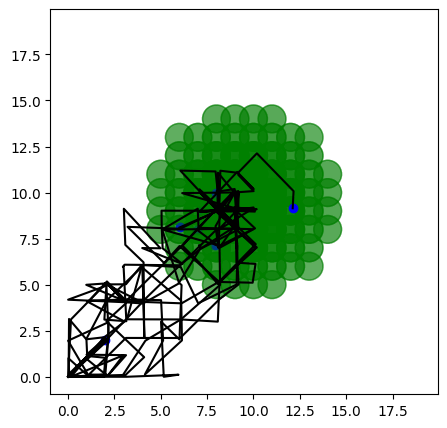

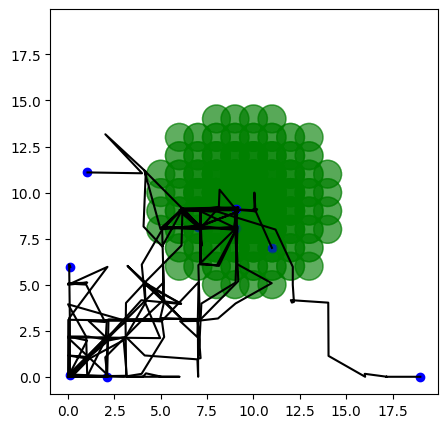

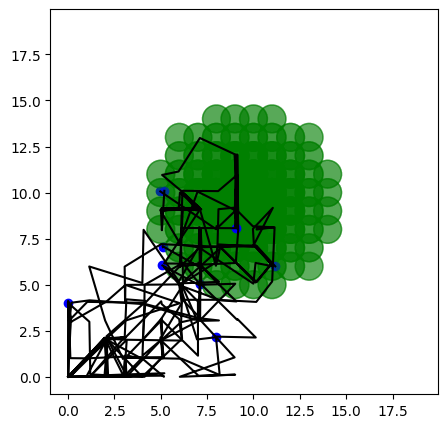

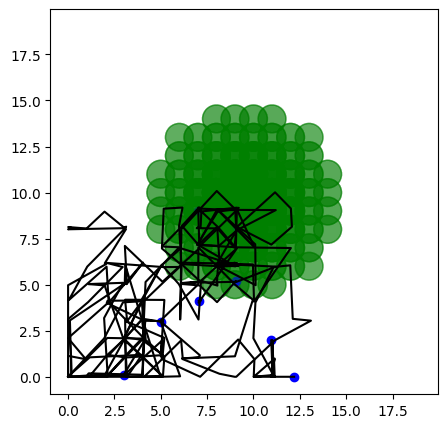

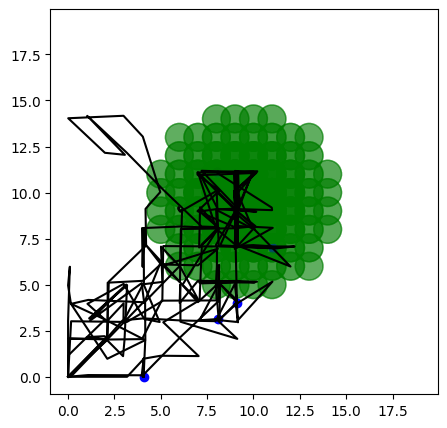

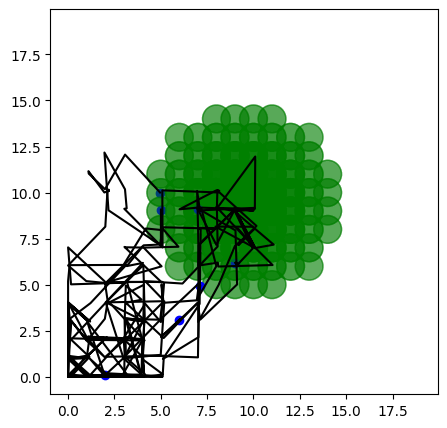

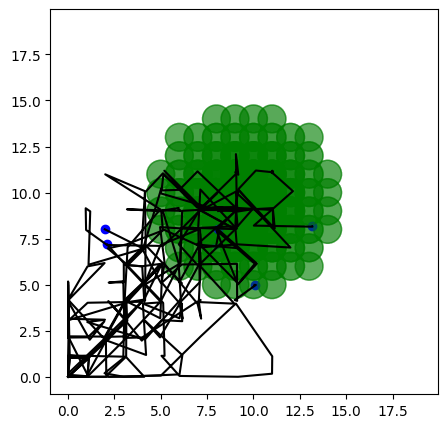

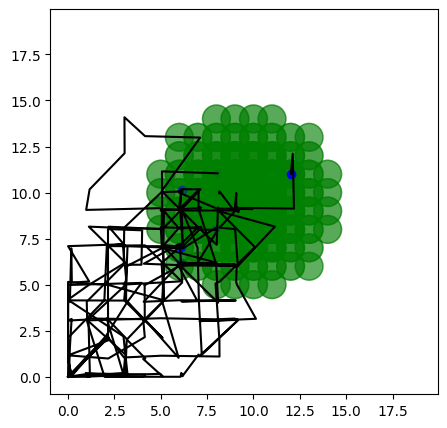

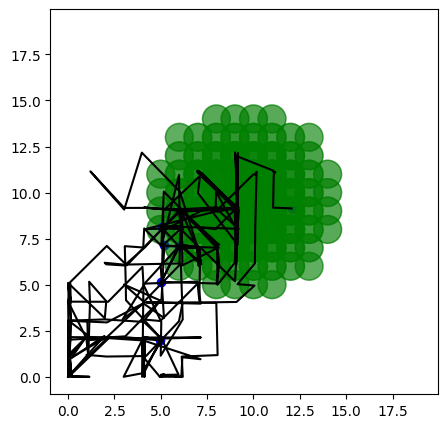

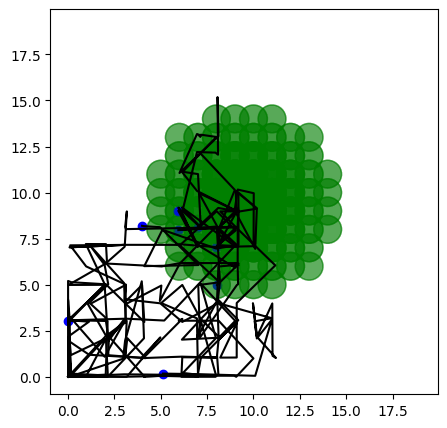

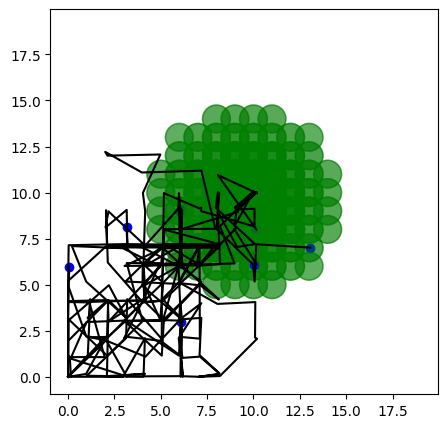

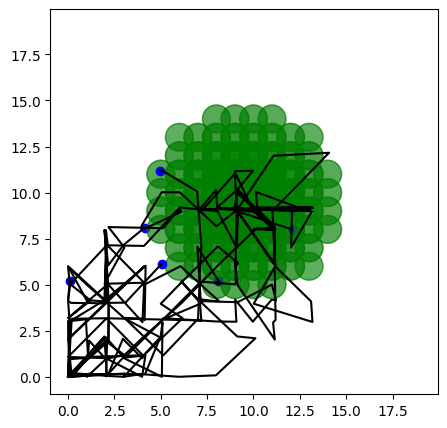

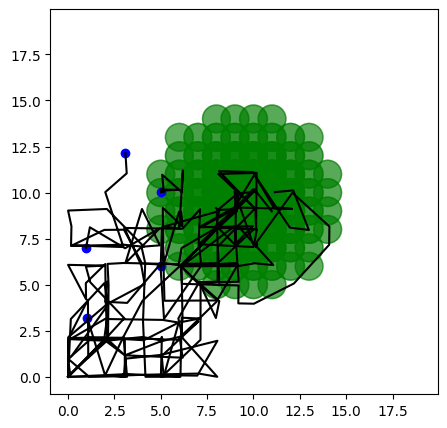

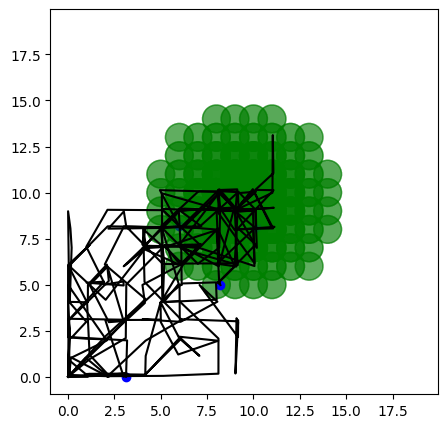

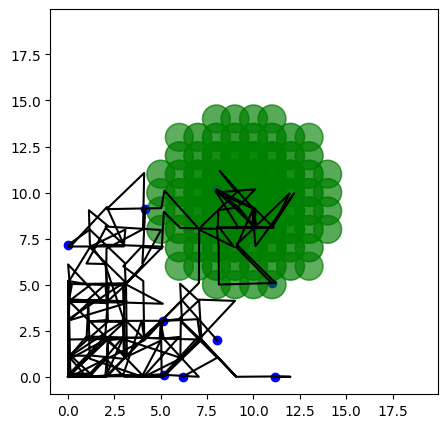

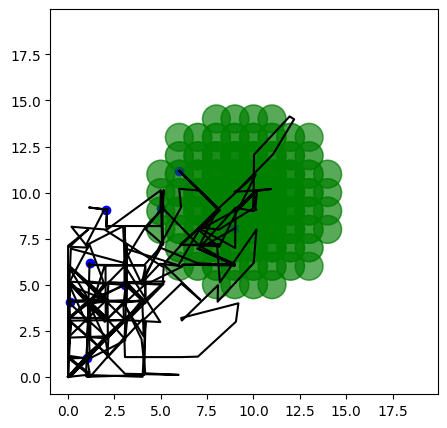

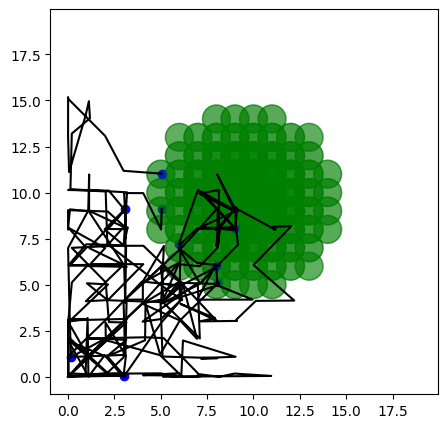

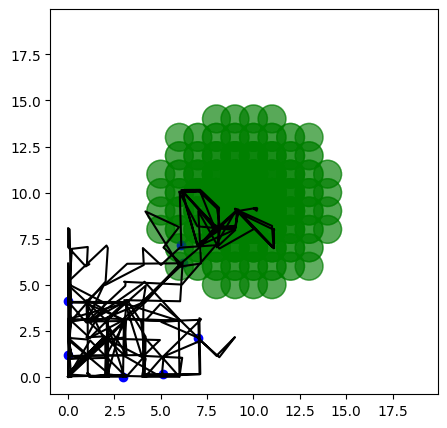

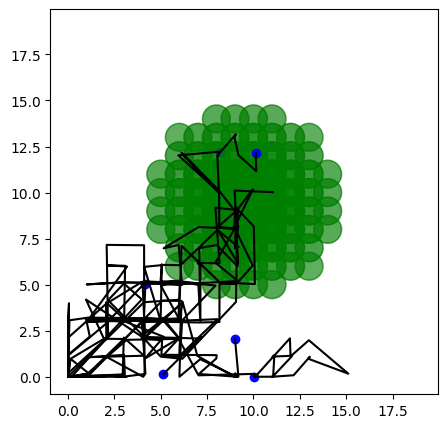

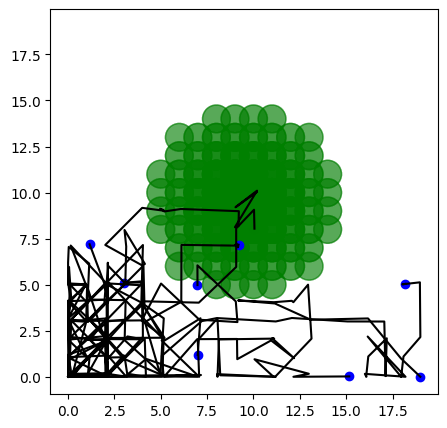

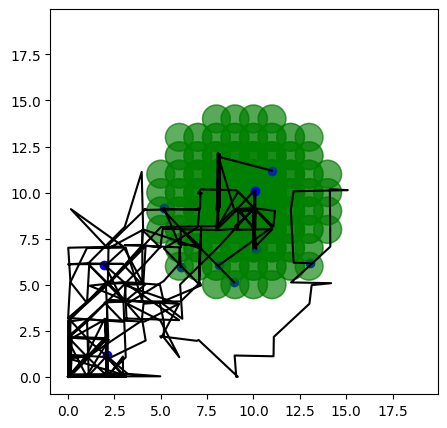

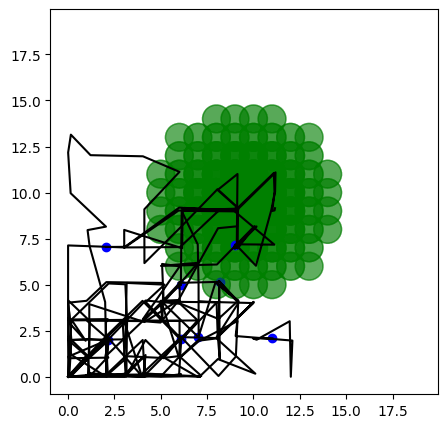

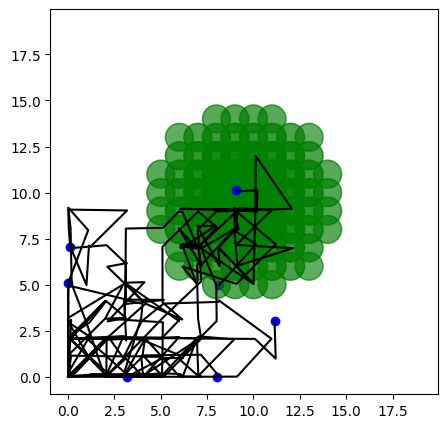

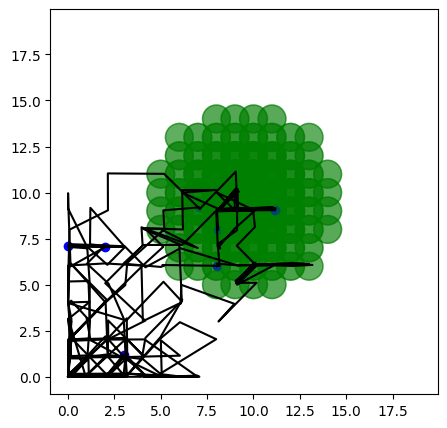

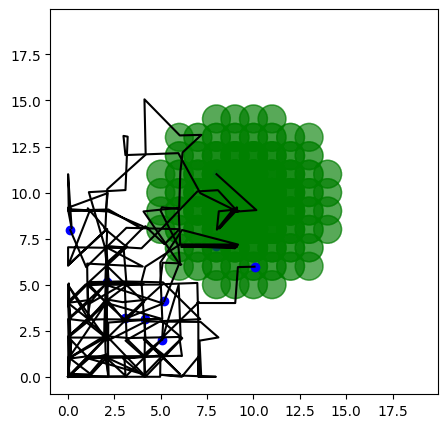

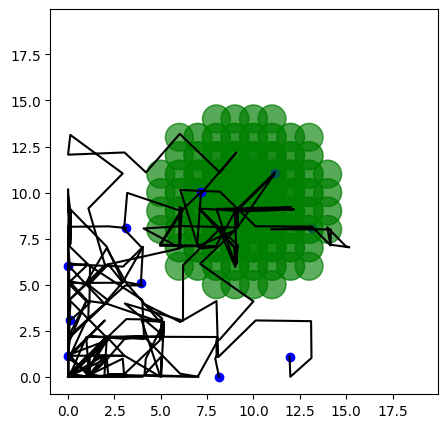

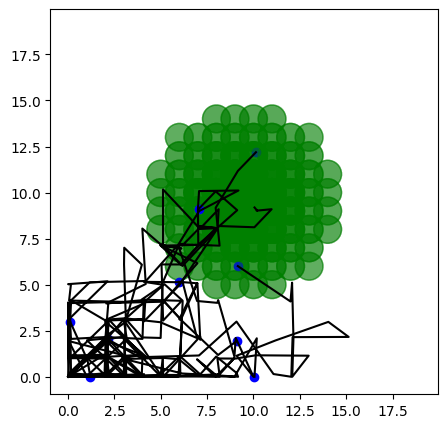

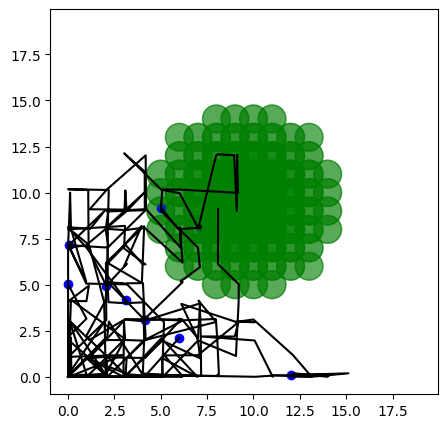

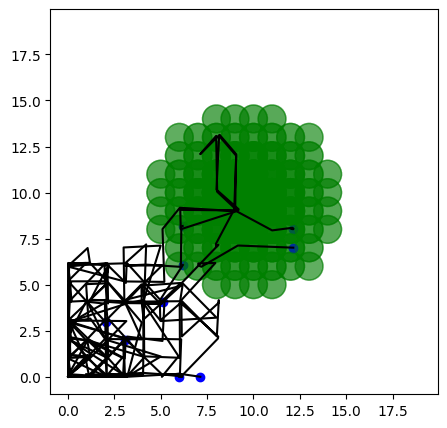

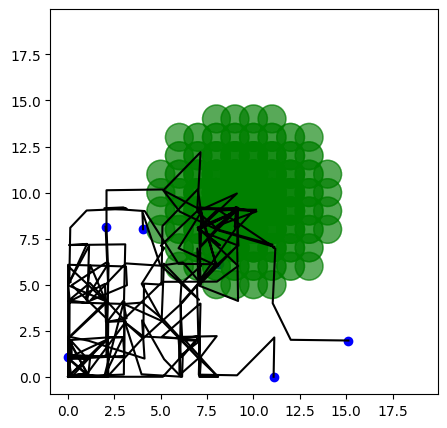

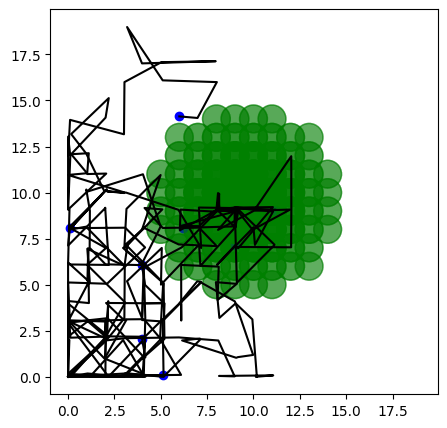

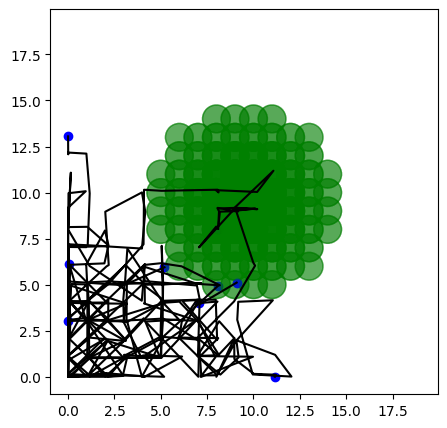

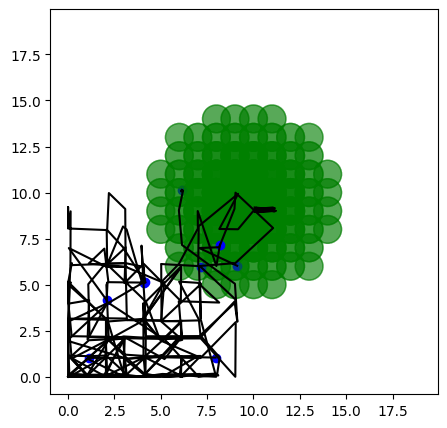

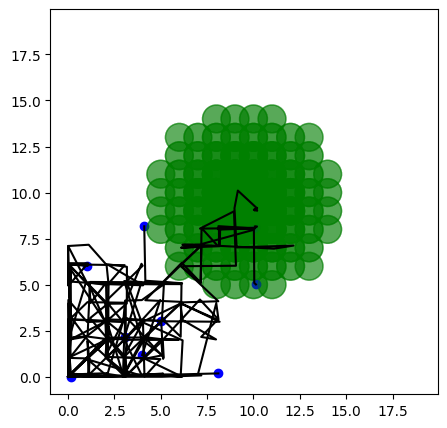

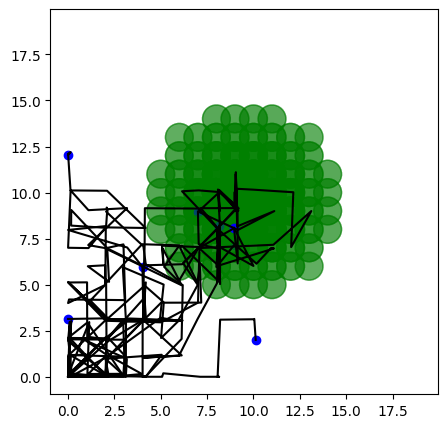

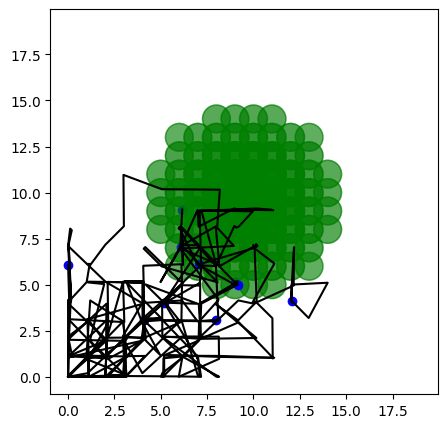

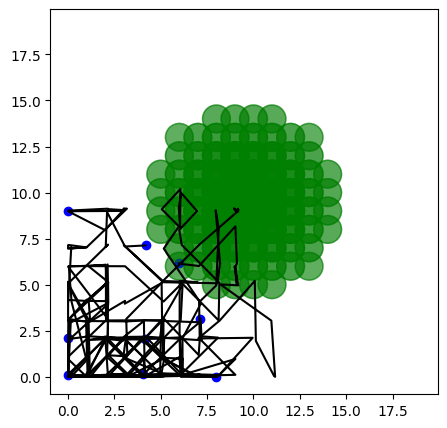

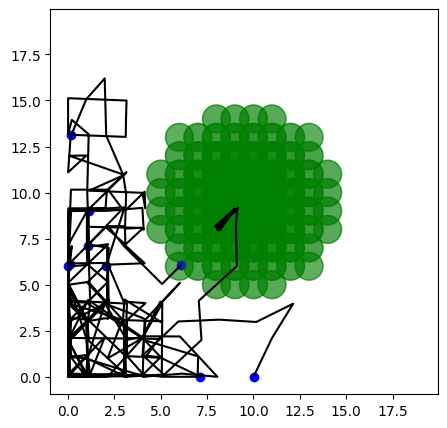

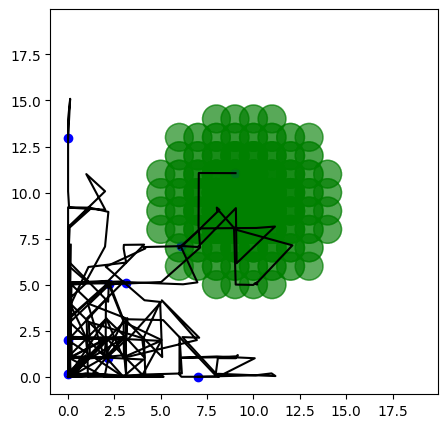

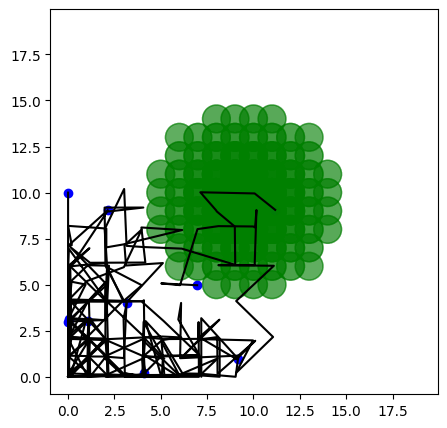

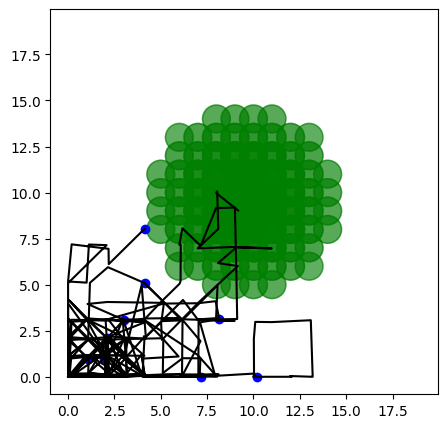

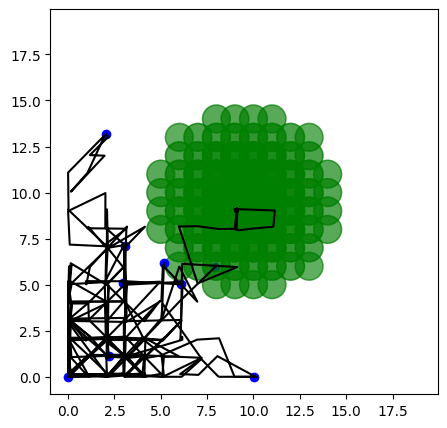

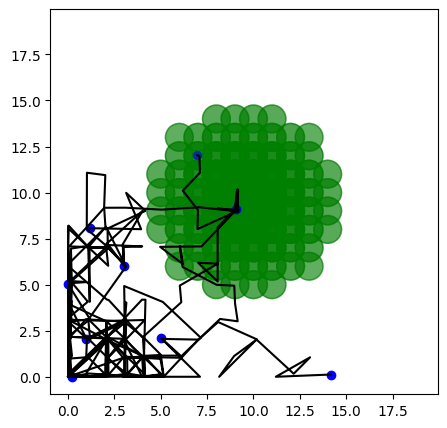

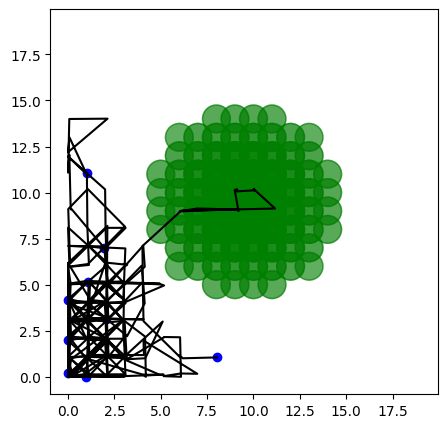

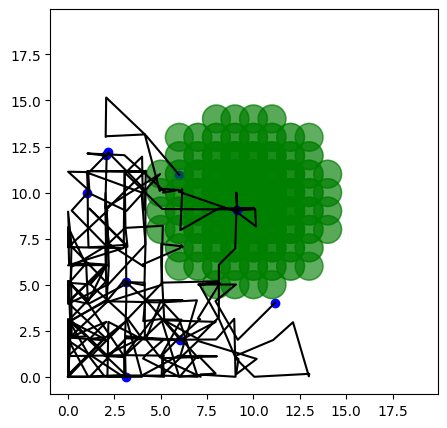

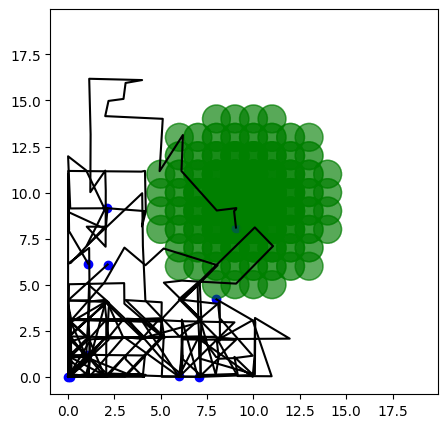

In [ ]:
#Testing something below:
for percI in range(75):
  perc = percI/100
  plt.figure(figsize=(5, 5))
  for run in range(10):

    #Define the (x,y) path of agent
    agentWithBrownian = agent(alpha,gamma,epsilon, steepness)
    agentWithBrownian.trainQTable(1000, perc)
    xAgent, yAgent = agentWithBrownian.simulate(30, perc)

    #Define the gradient
    gradientWithBrownian = gradient(19,19)
    xGradient, yGradient, alphaGradient = gradientWithBrownian.createGradient(steepness) # Call createGradient method

    #Define the plot
    plt.plot(xAgent, yAgent, c = 'black')
    plt.scatter(xGradient, yGradient, c = 'green', s = 400, alpha = alphaGradient)

    #Graph final position as different colored pt
    plt.scatter(xAgent[-1], yAgent[-1], c = "blue")

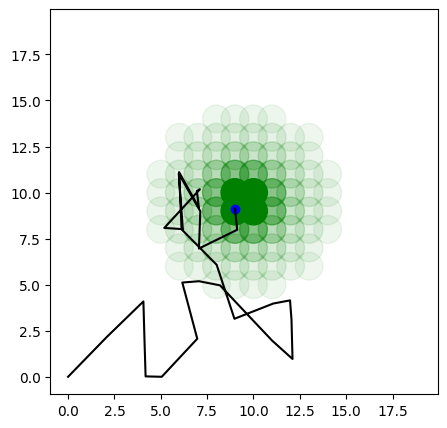

In [ ]:
plt.figure(figsize=(5, 5))

#test percentage change in epsilon inside and outside gradient
perc = 0.35

#Define the (x,y) path of agent
agentWithBrownian = agent(alpha,gamma,epsilon, steepness)
agentWithBrownian.trainQTable(1000, perc)
xAgent, yAgent = agentWithBrownian.simulate(30, perc)

#Define the gradient
gradientWithBrownian = gradient(19,19)
xGradient, yGradient, alphaGradient = gradientWithBrownian.createGradient(steepness) # Call createGradient method

#Define the plot
plt.plot(xAgent, yAgent, c = 'black')
plt.scatter(xGradient, yGradient, c = 'green', s = 400, alpha = alphaGradient)

#Graph final position as different colored pt
plt.scatter(xAgent[-1], yAgent[-1], c = "blue")

/tmp/ipython-input-1055010695.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


KeyboardInterrupt: 

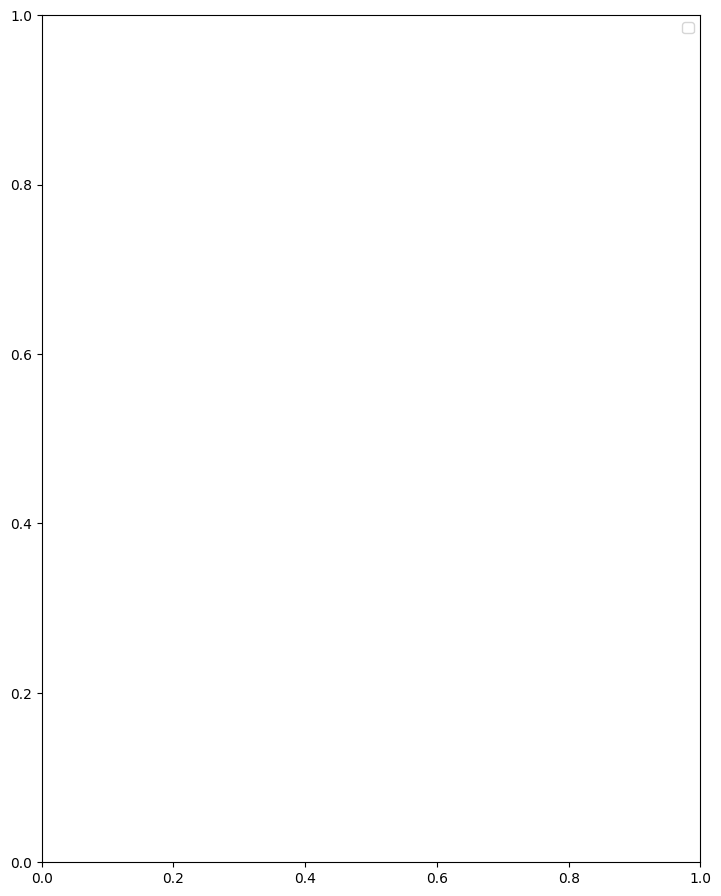

In [ ]:
#Simulate the 3 key graphs
agentGraph = graphs(alpha,gamma,epsilon, steepness)

#establish everything
plt.figure(figsize=(8.5, 11))
plt.legend()

#graph average distance from center
stepsDist, avgDist = agentGraph.graphOfAverageDist()
plt.plot(stepsDist,avgDist, color = "blue", label = "Distance From Center")

#graph average change in distance fro center
stepsChangeDist, avgChangeDist = agentGraph.graphOfAverageDistChange()
plt.plot(stepsChangeDist, avgChangeDist, color = "orange", label = "Change In Distance From Center")

#create reference line for y=0
xLine = []
yLine = []
for i in range(30):
  xLine.append(i)
  yLine.append(0)
plt.plot(xLine, yLine, linestyle = "dashed", color = "black")

#graph the step where the agent reaches the center on average as x=step
avgStep = agentGraph.graphStepsToCenter()
xStep = []
yStep = []
for y in range(-1,15):
  yStep.append(y)
  xStep.append(avgStep)
plt.plot(xStep, yStep, linestyle = "dashdot", color = "green", label = "Gradient Reaching Step")
plt.plot([avgStep-1,avgStep+1], [-1,-1], linestyle = "dashdot", color = "green")
plt.plot([avgStep-1,avgStep+1], [14,14], linestyle = "dashdot", color = "green")

#graph best and worst results
xBest, yBest = agentGraph.graphBest()
plt.plot(xBest, yBest, color = "green", linestyle = "dotted", label= "Best Case")

xWorst, yWorst = agentGraph.graphWorst()
plt.plot(xWorst, yWorst, color = "red", linestyle = "dotted", label = "Worst Case")

plt.title("Huerisitc Key Graphs at Gamma: " + str(gamma) + ", Alpha: " + str(alpha)+", and Steepness: " + str(steepness)  )
plt.xlabel("Steps")
plt.ylabel("Distance")
plt.legend()